<a href="https://colab.research.google.com/github/galbendavids/deep_learning_projects/blob/main/music_lyrics_genrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Music part

In [ ]:
!pip install pretty_midi

import pretty_midi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pathlib


import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

     |████████████████████████████████| 5.6MB 8.3MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591954 sha256=ef617b5af0bd771602eba809ed7b1886ce6da709a95bbcdbf36bf963538206f1
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
MAX_LINE = 150
NEW_LINE = "endline"

In [ ]:
def match_midi_files_to_dataset(path_to_midi, path_to_csv, test_dataset=False):
    """
    this method match between record in the csv that contain the lyrices 
    to the correct midi file that contain the melody
    """
    midi_files = list(pathlib.Path(path_to_midi).iterdir())
    match_midi_to_lyrics = {}
    midi_files_compare = [midi.stem.lower() for midi in midi_files]
    cols=['artist', 'song_name', 'lyrics'] 
    dataset = pd.read_csv(path_to_csv, usecols=[0,1,2], names=cols,)
    saw_raw =  []
    for index_dataset in range(len(dataset)):
        flag = False
        for index, midi in enumerate(midi_files_compare):
            if test_dataset:
                artist_with_song_name = dataset.artist[index_dataset].replace(" ", "_") + "_-" + dataset.song_name[index_dataset].replace(" ", "_")
            else:
                artist_with_song_name = dataset.artist[index_dataset].replace(" ", "_") + "_-_" + dataset.song_name[index_dataset].replace(" ", "_")
            if artist_with_song_name  == midi:
                if artist_with_song_name not in saw_raw:
                    saw_raw.append(artist_with_song_name)
                else:
                    print(f"apperas twice: {artist_with_song_name}")
                    continue
                flag = True
                match_midi_to_lyrics[index_dataset] = midi_files[index]
                break
        if flag == False:
            print(f"not found: {artist_with_song_name}")
            match_midi_to_lyrics[index_dataset] = None 
    return match_midi_to_lyrics

In [ ]:
def read_piano_roll(match_midi_to_lyrics):
    """
    this method load the piano roll matrix of the MIDI data.
    """
    PITCH_NUMBER = 128
    MELODY_LENGTH = 2
    song_to_piano_roll = {}
    for key, value in match_midi_to_lyrics.items():
        try:
            # if there is not mifi file match the lyrices, set zero 
            # as the melody
            if value is None:
                song_to_piano_roll[key] = np.zeros((PITCH_NUMBER, MAX_LINE * MELODY_LENGTH))
                continue
            pm = pretty_midi.PrettyMIDI(str(value))
            piano_roll = pm.get_piano_roll(fs=1)
            song_to_piano_roll[key] = piano_roll
        # some midi files fail on the load command, so we set zeros in thier melody
        except Exception as e:
            print("failed to read the file:")
            print(value)
            print(e)
            song_to_piano_roll[key] = np.zeros((PITCH_NUMBER, MAX_LINE * MELODY_LENGTH))
    return song_to_piano_roll

In [ ]:
def read_his(match_midi_to_lyrics):
    """
    this method load the histogram of pitch classes of each midi file.
    """
    LEN_OF_HIST = 12 
    song_to_hist = {}
    for key, value in match_midi_to_lyrics.items():
        try:
            # if there is not mifi file match the lyrices, set zero 
            # as the histogram
            if value is None:
                song_to_hist[key] = np.zeros((LEN_OF_HIST))
                continue
            pm = pretty_midi.PrettyMIDI(str(value))
            histogram = pm.get_pitch_class_histogram()
            song_to_hist[key] = histogram
        # some midi files fail on the load command, so we set zeros in thier melody
        except Exception as e:
            print(value)
            print(e)
            song_to_hist[key] = np.zeros((LEN_OF_HIST))
    return song_to_hist

In [ ]:
def slice_piano_roll(match_midi_to_lyrics):
    """
    this method slice the content of the piano roll to servel bins with shape of:
    (MAX_LINE, 128) if the shape is less than MAX_LINE a of zeros is added
    """
    song_to_slice_piano_roll = {}
    x = []
    for key, value in match_midi_to_lyrics.items():
            value = value.T
            song_to_slice_piano_roll[key] = []
            for index in range(0, value.shape[0], MAX_LINE):
                piano_roll = value[index:index + MAX_LINE, :]
                if piano_roll.shape[0] < MAX_LINE:
                    pad_piano_roll = np.pad(piano_roll,
                                      [(0, (1*(MAX_LINE - piano_roll.shape[0]))), (0, 0)],
                                      mode='constant',
                                      constant_values=0)
                    song_to_slice_piano_roll[key].append(pad_piano_roll)
                else:
                    song_to_slice_piano_roll[key].append(piano_roll)    
            song_to_slice_piano_roll[key] = np.array(song_to_slice_piano_roll[key])
    return song_to_slice_piano_roll

In [ ]:
def replace_new_line(path_to_csv):
    """
    this method replace the char & which not recognized by TextVectorization with
    a NEW_LINE string
    """
    col=['artist', 'song_name', 'lyrics'] 
    dataset = pd.read_csv(path_to_csv, usecols =[0,1,2],names=col,)

    lyrics_col = dataset['lyrics']
    new_lyrics_col=[]
    for lyrics in lyrics_col:
        new_lyrics=lyrics.replace('&', NEW_LINE)
        new_lyrics_col.append(new_lyrics)
    
    dataset['lyrics']=new_lyrics_col
    print(dataset.head())
    return dataset

In [ ]:
def create_vectorizer(dataset_train, dataset_test):
    """
    this method create vectorizer from the train and test dataset
    """
    vectorizer = TextVectorization(max_tokens=100000, output_sequence_length=MAX_LINE)
    text_ds = tf.data.Dataset.from_tensor_slices(dataset_train["lyrics"].tolist() + dataset_test["lyrics"].tolist())
    vectorizer.adapt(text_ds)
    return vectorizer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-05-24 18:35:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-24 18:35:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-24 18:35:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
def create_embeddings(path_to_file):
    """
    this method load the embeddings from the pre train word2vec file
    """
    embeddings = {}
    with open(path_to_file) as word2vec_file:
        for line in word2vec_file:
            word, vector = line.split(maxsplit=1)
            vector = np.fromstring(vector, "f", sep=" ")
            embeddings[word] = vector
    return embeddings

In [ ]:
def create_embedding_matrix(num_tokens, embedding_dim, word_index, embeddings_index):
    """
    this method create an embdedding matrix that match between the words in the
    datasets to their match vector in the pre-train word2vec
    if there is not match word a random vector is generate
    """
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, index in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.random.rand(embedding_dim)
    return embedding_matrix

In [ ]:
def create_model_dataset1(vectorizer, match_lyrics_to_melody, dataset):
    """
    this method represnet the first approch to combine the melody
    with the lyrics.
    each song is split to several sequence with the size of
    MAX_LINE, for each sequence a part of the melody is 
    added (the melody is splitted to servel bins after the method slice_piano_roll)
    if the number of sequences of a song is bigger from the number of melody bins
    with add a vector of zero
    """
    x = []
    y = []
    melody = []
    for key, value in match_lyrics_to_melody.items():
        lyrics =  dataset["lyrics"][key].split(" ")
        for index in range(0, len(lyrics), MAX_LINE):
            split_lyrics =  lyrics[index:index+MAX_LINE]
            x.append(" ".join(split_lyrics[:-1]))
            y.append(" ".join(split_lyrics[1:]))

            index_in_melody = int(index / MAX_LINE)
            if index_in_melody < len(value):
                melody.append(np.array(value[index_in_melody]))
            # if the number of splited lyrics is bigger then the size of
            # the splitted metlody, set zeros as the melody
            else:
                melody.append(np.zeros(value[0].shape))

    x = vectorizer(np.array([[sequence] for sequence in x])).numpy()
    y = vectorizer(np.array([[sequence] for sequence in y])).numpy()
    return x, y, melody

In [ ]:
def create_model_dataset2(vectorizer, match_lyrics_to_hist, dataset):
    """
    this method represnet the second approch to combine the melody 
    with the lyrics.
    each song is split to serverl sequence with the size of
    MAX_LINE, for each sequence w add the same vector that generate from the 
    method read_his
    """
    x = []
    y = []
    hist = []
    for key, value in match_lyrics_to_hist.items():
        lyrics =  dataset["lyrics"][key].split(" ")
        for index in range(0, len(lyrics), MAX_LINE):
            split_lyrics =  lyrics[index:index+MAX_LINE]
            x.append(" ".join(split_lyrics[:-1]))
            y.append(" ".join(split_lyrics[1:]))
            hist.append(np.array([value,] * MAX_LINE))

    x = vectorizer(np.array([[sequence] for sequence in x])).numpy()
    y = vectorizer(np.array([[sequence] for sequence in y])).numpy()
    return x, y, hist

In [ ]:
def create_model1(num_tokens, embedding_dim, embedding_matrix):
    """
    this method create the first model
    """
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=True,
    )
    lyrics_input = tf.keras.Input(shape=(MAX_LINE,), dtype="int64")
    embedded_lyrics = embedding_layer(lyrics_input)
    melody_input = tf.keras.Input(shape=(MAX_LINE, 128, ))
    merge = tf.keras.layers.concatenate([embedded_lyrics, melody_input], axis=2)
    next_layer = tf.keras.layers.LSTM(units=MAX_LINE, return_sequences=True)(merge)
    next_layer = Dropout(0.3)(next_layer)
    next_layer = Dense(num_tokens/4, activation='relu')(next_layer)
    next_layer = Dense(num_tokens, activation='softmax')(next_layer)
    model = tf.keras.models.Model([lyrics_input, melody_input], next_layer)
    return model

In [ ]:
def create_model2(num_tokens, embedding_dim, embedding_matrix):
    """
    this method create the second model
    """
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=True,
    )
    lyrics_input = tf.keras.Input(shape=(MAX_LINE,), dtype="int64")
    embedded_lyrics = embedding_layer(lyrics_input)
    melody_input = tf.keras.Input(shape=(MAX_LINE, 12, ))
    merge = tf.keras.layers.concatenate([embedded_lyrics, melody_input], axis=2)
    next_layer = tf.keras.layers.LSTM(units=MAX_LINE, return_sequences=True)(merge)
    next_layer = Dropout(0.3)(next_layer)
    next_layer = Dense(num_tokens/4, activation='relu')(next_layer)
    next_layer = Dense(num_tokens, activation='softmax')(next_layer)
    model = tf.keras.models.Model([lyrics_input, melody_input], next_layer)
    return model

In [ ]:
def train_model(model, x_train, x_pm_train, y_train, x_val, x_pm_val, y_val):
    """
    this method train the model and return the history of the training process
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    history = model.fit([x_train, x_pm_train] , y_train, epochs=30, verbose=1, validation_data=([x_val, x_pm_val], y_val))
    return history

In [ ]:
def data_prep1():
    """
    this method preform the pre-processing of the data, 
    first the method create a dict that match between the lyrics
    and the midi file, than the method read the piano_roll of the midi file, 
    and slice to serveal bins so he can be later concat with the lyrics
    """
    match_midi_to_lyrics_train = match_midi_files_to_dataset("/content/drive/MyDrive/midi_files",
                                                             "/content/drive/MyDrive/lyrics_train_set.csv")
    match_midi_to_lyrics_test = match_midi_files_to_dataset("/content/drive/MyDrive/midi_files",
                                                            "/content/drive/MyDrive/lyrics_test_set.csv",
                                                            test_dataset=True)
    match_lyrics_to_piano_roll_train = read_piano_roll(match_midi_to_lyrics_train)
    match_lyrics_to_piano_roll_test =  read_piano_roll(match_midi_to_lyrics_test)
    match_lyrics_to_slice_piano_roll_train = slice_piano_roll(match_lyrics_to_piano_roll_train)
    match_pm_to_lyrics_test_filter_test =  slice_piano_roll(match_lyrics_to_piano_roll_test)
    return match_lyrics_to_slice_piano_roll_train, match_pm_to_lyrics_test_filter_test

In [ ]:
def data_prep2():
    """
    this method preform the pre-processing of the data, 
    first the method create a dict that match between the lyrics
    and the midi file, than the method read the histogram of the midi file.
    """
    match_midi_to_lyrics_train = match_midi_files_to_dataset("/content/drive/MyDrive/midi_files",
                                                             "/content/drive/MyDrive/lyrics_train_set.csv")
    match_midi_to_lyrics_test = match_midi_files_to_dataset("/content/drive/MyDrive/midi_files",
                                                            "/content/drive/MyDrive/lyrics_test_set.csv",
                                                            test_dataset=True)
    match_lyrics_to_hist_train = read_his(match_midi_to_lyrics_train)
    match_lyrics_to_hist_test =  read_his(match_midi_to_lyrics_test)
    return match_lyrics_to_hist_train, match_lyrics_to_hist_test

In [ ]:
def read_csv_and_create_embeddings(dataset_train, dataset_test):
    
    vectorizer = create_vectorizer(dataset_train, dataset_test)
    vocabulary = vectorizer.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    path_to_word2vec_file = "glove.6B.300d.txt"
    embeddings_index = create_embeddings(path_to_word2vec_file)
    num_tokens = len(vocabulary) + 2
    embedding_dim = 300
    embedding_matrix = create_embedding_matrix(num_tokens,
                                               embedding_dim,
                                               word_index,
                                               embeddings_index)
    return embedding_matrix, embedding_dim, num_tokens, vectorizer, vocabulary

In [ ]:
def split_train_val_test(vectorizer,
                         match_midi_to_lyrics_train,
                         dataset_train,
                         match_midi_to_lyrics_test,
                         dataset_test,
                         model_number=1):
    """
    this method creates the train, val and test set from the model
    """
    if model_number == 1:
        x_train, y_train, pm_train = create_model_dataset1(vectorizer,
                                                        match_midi_to_lyrics_train,
                                                        dataset_train)
        x_test, y_test, pm_test = create_model_dataset1(vectorizer,
                                                        match_midi_to_lyrics_test,
                                                        dataset_test)
    
    else:
        x_train, y_train, pm_train = create_model_dataset2(vectorizer,
                                                        match_midi_to_lyrics_train,
                                                        dataset_train)
        
        x_test, y_test, pm_test = create_model_dataset2(vectorizer,
                                                        match_midi_to_lyrics_test,
                                                        dataset_test)
    
    num_of_samples = x_train.shape[0]
    random_indexs = np.random.permutation(num_of_samples)
    train_indexs, val_indexs = random_indexs[:int(num_of_samples * 0.8)], random_indexs[int(num_of_samples * 0.8):]

    x_train, x_val = x_train[train_indexs], x_train[val_indexs]
    y_train, y_val = y_train[train_indexs], y_train[val_indexs]

    pm_train = np.array(pm_train)
    pm_test = np.array(pm_test)
    x_pm_train, x_pm_val = pm_train[train_indexs], pm_train[val_indexs]

    return (x_train, x_pm_train, y_train), (x_val, x_pm_val, y_val), (x_test, y_test, pm_test)

In [ ]:
def generate(word, word_pm, num, model, vectorizer, vocabulary):
    """
    this method generate a song from a given word
    """
    long_word = word
    inputs = vectorizer([word])
    NUM_OF_WORD_TO_GEN = MAX_LINE - 30
    while num <= NUM_OF_WORD_TO_GEN:
        pred = model.predict([inputs, word_pm])
        # return the best match 
        #index = np.argmax(pred[0][num])
        
        # return on of the there best match
        index = np.argsort(pred[0][num])[-10:][np.random.randint(10)]
        long_word = long_word + " " + vocabulary[index]
        inputs = vectorizer([long_word])
        num += 1
    print(long_word.replace(" " + NEW_LINE + " ", "\n"))

In [ ]:
def generate_test_lyrics(dataset_test, pm_test, model, vectorizer, vocabulary, random_indexes):
    """
    this method generate a new song from the test datasets
    """
    
    for index in range(len(dataset_test)):
        print(f"melody number: {index + 1}")
        print("generate 3 different lyrics")
        for i in range(3):
            genearte_index_in_voc = random_indexes[i]
            print(f"generate lyrics number {i + 1} for melody number {index + 1}")
            first_word = vocabulary[genearte_index_in_voc]
            print(f"start with the word {first_word}")
            word_pm = pm_test[index:index+1]
            generate(first_word, word_pm, 0, model, vectorizer, vocabulary)
            print("***********************************")
        print(f"finish song number : {index + 1}\n")
        print("=======================================")

In [ ]:
def plot(history):
    """ 
    this method plot the accuracy and the loss of the network
    """
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [ ]:
def run_model1():
    match_midi_to_lyrics_train, match_midi_to_lyrics_test = data_prep1()
    dataset_train = replace_new_line('/content/drive/MyDrive/lyrics_train_set.csv')
    dataset_test = replace_new_line('/content/drive/MyDrive/lyrics_test_set.csv')
    embedding_matrix, embedding_dim, num_tokens, vectorizer, vocabulary = read_csv_and_create_embeddings(dataset_train, dataset_test)
    train, val, test = split_train_val_test(vectorizer,
                                            match_midi_to_lyrics_train,
                                            dataset_train,
                                            match_midi_to_lyrics_test,
                                            dataset_test,
                                            model_number=1)
    x_train, x_pm_train, y_train = train 
    x_val, x_pm_val, y_val = val
    x_test, y_test, pm_test = test

    model1 = create_model1(num_tokens, embedding_dim, embedding_matrix)

    tf.keras.utils.plot_model(model1, show_shapes=True)
    history1 = train_model(model1, x_train, x_pm_train, y_train, x_val, x_pm_val, y_val)
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    random_indexes = []
    random_indexes.append(word_index["star"])
    random_indexes.append(word_index["dreamworld"])
    random_indexes.append(word_index["gratitude"])
        
    generate_test_lyrics(dataset_test, pm_test, model1, vectorizer, vocabulary, random_indexes)
    plot(history1)
    return random_indexes

In [ ]:
def run_model2(random_indexes):
    match_midi_to_lyrics_train, match_midi_to_lyrics_test = data_prep2()
    dataset_train = replace_new_line('/content/drive/MyDrive/lyrics_train_set.csv')
    dataset_test = replace_new_line('/content/drive/MyDrive/lyrics_test_set.csv')
    embedding_matrix, embedding_dim, num_tokens, vectorizer, vocabulary = read_csv_and_create_embeddings(dataset_train, dataset_test)
    train, val, test = split_train_val_test(vectorizer,
                                            match_midi_to_lyrics_train,
                                            dataset_train,
                                            match_midi_to_lyrics_test,
                                            dataset_test,
                                            model_number=2)
    x_train, x_pm_train, y_train = train 
    x_val, x_pm_val, y_val = val
    x_test, y_test, pm_test = test

    model2 = create_model2(num_tokens, embedding_dim, embedding_matrix)

    tf.keras.utils.plot_model(model2, show_shapes=True)
    history2 = train_model(model2, x_train, x_pm_train, y_train, x_val, x_pm_val, y_val)
    generate_test_lyrics(dataset_test, pm_test, model2, vectorizer, vocabulary, random_indexes)
    plot(history2)

In [ ]:
def main():
    print("run model 1")
    #generate random words in the first model and pass them to the second model
    random_indexes = run_model1()
    print("run model 2")
    run_model2(random_indexes)

run model 1
not found: eric_clapton_-_wonderful_tonight
apperas twice: all_4_one_-_i_swear
not found: all_4_one_-_i_swear
not found: depeche_mode_-_enjoy_the_silence
not found: depeche_mode_-_enjoy_the_silence
not found: ed_sheeran_-_thinking_out_loud


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


failed to read the file:
/content/drive/MyDrive/midi_files/Beastie_Boys_-_Girls.mid
Could not decode key with 1 flats and mode 255
failed to read the file:
/content/drive/MyDrive/midi_files/Billy_Joel_-_Movin'_Out.mid
data byte must be in range 0..127
failed to read the file:
/content/drive/MyDrive/midi_files/Billy_Joel_-_Pressure.mid
data byte must be in range 0..127
failed to read the file:
/content/drive/MyDrive/midi_files/Dan_Fogelberg_-_Leader_of_the_Band.mid
Could not decode key with 4 flats and mode 255
failed to read the file:
/content/drive/MyDrive/midi_files/Brian_McKnight_-_On_The_Down_Low.mid

failed to read the file:
/content/drive/MyDrive/midi_files/Aaron_Neville_-_Tell_It_Like_It_Is.mid
data byte must be in range 0..127
           artist  ...                                             lyrics
0      elton john  ...  goodbye norma jean endline though i never knew...
1  gerry rafferty  ...  winding your way down on baker street endline ...
2  gerry rafferty  ...  you know 

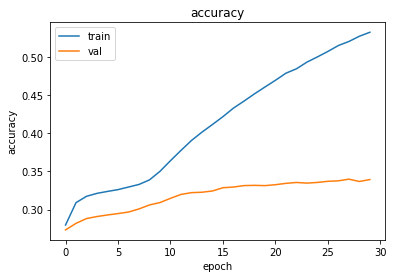

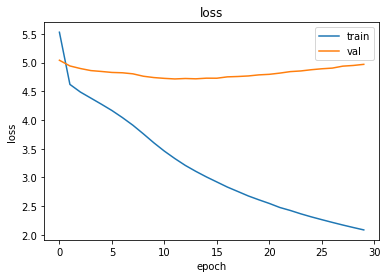

run model 2
not found: eric_clapton_-_wonderful_tonight
apperas twice: all_4_one_-_i_swear
not found: all_4_one_-_i_swear
not found: depeche_mode_-_enjoy_the_silence
not found: depeche_mode_-_enjoy_the_silence
not found: ed_sheeran_-_thinking_out_loud


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


/content/drive/MyDrive/midi_files/Beastie_Boys_-_Girls.mid
Could not decode key with 1 flats and mode 255
/content/drive/MyDrive/midi_files/Billy_Joel_-_Movin'_Out.mid
data byte must be in range 0..127
/content/drive/MyDrive/midi_files/Billy_Joel_-_Pressure.mid
data byte must be in range 0..127
/content/drive/MyDrive/midi_files/Dan_Fogelberg_-_Leader_of_the_Band.mid
Could not decode key with 4 flats and mode 255
/content/drive/MyDrive/midi_files/Brian_McKnight_-_On_The_Down_Low.mid

/content/drive/MyDrive/midi_files/Aaron_Neville_-_Tell_It_Like_It_Is.mid
data byte must be in range 0..127
           artist  ...                                             lyrics
0      elton john  ...  goodbye norma jean endline though i never knew...
1  gerry rafferty  ...  winding your way down on baker street endline ...
2  gerry rafferty  ...  you know i need your love endline you've got t...
3     2 unlimited  ...  come on check it out ya'll endline (come on co...
4     2 unlimited  ...  let the bea

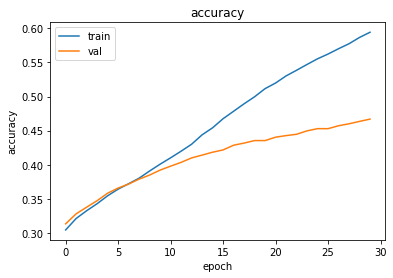

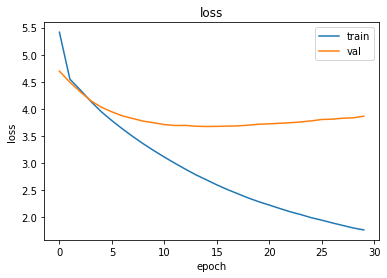

In [ ]:
main()